# Assignment 4 Analysis

In [10]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import reverse_geocoder as rg
import geopy
import geopy.distance as gd
from geopy.distance import vincenty
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = "andrewtan-stat159")
sys.path.insert(0, '/Users/andrewtan/stat159/cwcc-g11/')

In this assignment, we split Alameda County into West Alameda and East Alameda based on the 2 zipcodes 94552 and 94539. The points we're interested in classifying are the same Alameda County grid points we collected in Assignment 2. All points in or west of those 2 zipcodes are considered West Alameda. All points east of those 2 zipcodes are considered East Alameda. Given these 2 new sets of grid points, repeat the procedures from Assignments 2 and 3 for East Alameda and West Alameda separately. It took two key steps to divide the grid points into east and west. First, we found the westernmost point of East Alameda (border_west) and the easternmost point of West Alameda (border_east) using Google Maps. All points to the west of border_west are considered West Alameda, and all points to the east of this border_east are considered East Alameda. For points that lie between border_west and border_east, we looked up their zipcodes using geolocator and manually checked if they are east or west of the divider. One point did not produce a zipcode, so we visually checked its location on Google Maps.

### Import Functions

Get functions from previous assignments.

In [2]:
# from Assignment 2

def get_alameda_county_points():
    """ Calculates all the grid points (lat, lon) inside Alameda County
    Grid automatically includes Summit Reservoir (37.905098, -122.272225)
    Begin at northwest corner of bounding box and move in increment of 5 miles
    in the south and east directions until we reach the southeast corner,
    recording all grid points that fall inside Alameda County.

    return:
        list: list of (lat, lon) points inside Alameda County
    """
    # bounding box around Alameda County
    north = 38
    west = -122.4
    south = 37.4
    east = -121.4

    # grid automatically includes Summit Reservoir (37.905098, -122.272225)
    grid_points = [(37.905098, -122.272225)]
    curr = [north, west]

    # while current point is within the north / south bounds
    while curr[0] > south:
        # dynamically update lat and lon increment based on curr point
        destE = vincenty(miles=5).destination(curr, 90) # point 5 miles east of curr
        lon_increment = destE.longitude - curr[1]
        destS = vincenty(miles=5).destination(curr, 180) # point 5 miles south of curr
        lat_increment = curr[0] - destS.latitude

        # while current point is within the east / west bounds
        while curr[1] < east:
            if (rg.search(curr)[0]['admin2'] == "Alameda County"):
                grid_points.append(tuple(curr))
            curr[1] += lon_increment
        curr[0] -= lat_increment
        curr[1] = west

    return grid_points


def get_stations(grid_points, max_distance=10):
    """ Find all weather stations within max_distance (miles) from each of the grid points

    args:
        grid_points: list of grid points (lat, lon)
        max_distance: max distance to search around each grid point (default 10)
    return:
        list: list of weather stations (Series objects)
    """
    
    print(os.getcwd())
    station_data = pd.read_csv('Assignment2/data/stations_ca.csv')

    seen_stations = set()
    stations = []

    for point in grid_points:
        for index, station in station_data.iterrows():
            station_pos = (station['LATITUDE'], station['LONGITUDE'])
            if gd.vincenty(point, station_pos).miles <= max_distance and index not in seen_stations:
                seen_stations.add(index)
                stations.append(station)
    
    return stations


def get_station_weights(grid_points, max_distance=10):
    """ Returns a list of weights corresponding to all the weather stations around grid points

    args:
        grid_points: list of grid points (lat, lon)
        max_distance: max distance to search around each grid point (default 10) 
    return:
        list: list of station weights (floats), one for each station
    """
    stations = get_stations(grid_points, max_distance)
    station_pos = [(station['LATITUDE'], station['LONGITUDE']) for station in stations]
    station_weights = calc_inv_weighted_avg(grid_points, station_pos)
    return station_weights

In [3]:
# generate Alameda County grid points
grid_points = get_alameda_county_points()
print(len(grid_points))
stations = get_stations(grid_points, max_distance=10)
print(len(stations))
station_weights = get_station_weights(grid_points, stations, max_distance=10)
print(len(station_weights))

In [4]:
zip1 = 94552
zip2 = 94539
border_west = -122.06 # westernmost point of "East Alameda", points to the left are in West Alameda
border_east = -121.82 # easternmost point in "West Alameda", points to the right are in East Alameda

In [5]:
# Alameda County grid points copied from Assignment 2
grid_points = [(37.905098, -122.272225), (37.855007660508896, -122.30856533862595), (37.855007660508896, -122.2171306772519), (37.78251014815997, -122.30865472093605), (37.78251014815997, -122.21730944187209), (37.78251014815997, -121.7605830465523), (37.710011741493524, -122.30874378331349), (37.710011741493524, -122.21748756662697), (37.710011741493524, -122.12623134994045), (37.710011741493524, -122.03497513325394), (37.710011741493524, -121.94371891656742), (37.710011741493524, -121.8524626998809), (37.710011741493524, -121.76120648319439), (37.710011741493524, -121.66995026650787), (37.6375124410803, -122.12649758092323), (37.6375124410803, -122.03533010789764), (37.6375124410803, -121.94416263487204), (37.6375124410803, -121.85299516184645), (37.6375124410803, -121.76182768882086), (37.6375124410803, -121.67066021579527), (37.56501224749678, -122.12676285938359), (37.56501224749678, -122.03568381251145), (37.56501224749678, -121.94460476563931), (37.56501224749678, -121.85352571876717), (37.56501224749678, -121.76244667189503), (37.56501224749678, -121.6713676250229), (37.56501224749678, -121.58028857815076), (37.492511161325226, -122.03603625190428), (37.492511161325226, -121.94504531488035)]
grid_points = np.array(grid_points)

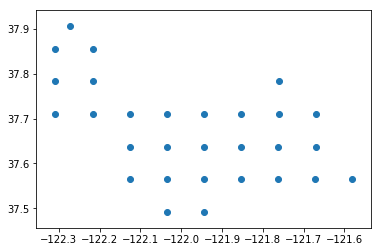

In [6]:
plt.scatter(grid_points[:, 1], grid_points[:, 0])

## Divide Alameda County to West and East

We split Alameda County into West Alameda and East Alameda based on the 2 zipcodes 94552 and 94539. The points we're interested in classifying are the same Alameda County grid points we collected in Assignment 2. All points in or west of those 2 zipcodes are considered West Alameda. All points east of those 2 zipcodes are considered East Alameda. Given these 2 new sets of grid points, repeat the procedures from Assignments 2 and 3 for East Alameda and West Alameda separately. It took two key steps to divide the grid points into east and west. First, we found the westernmost point of East Alameda (border_west) and the easternmost point of West Alameda (border_east) using Google Maps. All points to the west of border_west are considered West Alameda, and all points to the east of this border_east are considered East Alameda. For points that lie between `border_west` and `border_east`, we looked up their zipcodes using geolocator and manually checked if they are east or west of the divider. One point did not produce a zipcode, so we visually checked its location on Google Maps.

The 11 points between -122.1 and -121.8 in the above plot are the 11 points that lie between `border_west` and `border_east`. Of these points, 10 produced zip codes based on geolocator. For these 10 zip codes, we checked to see if they belonged to West or East Alameda. We stored this information in a dictionary called `zip_loc`. One point located at (37.63751244, -121.94416263) did not have a zip code. For this point, we checked Google Maps to confirm that it was Kilkare Woods and belonged to zipcode 94552, which is part of West Berkeley. From our analysis, we categorized 17 / 29 points as West Berkeley and 12 / 29 points as East Berkeley. We converted this into a function `divide_alameda_points` and put it into `assignment4.py`.

In [15]:
zip_loc = {
    'west': [94539, 94552, 94544, 94536, 94537, 94538],
    'east': [94568, 94566, 94586]
}

west_alameda = []
east_alameda = []

for point in grid_points:
    if point[1] < border_west:
        west_alameda.append(point)
    elif point[1] > border_east:
        east_alameda.append(point)
    else:
        try:
            unknown_zip = int(re.findall(r'\d+', geolocator.reverse(point).raw['address']['postcode'])[0])
            if unknown_zip in zip_loc['west']:
                west_alameda.append(point)
            elif unknown_zip in zip_loc['east']:
                east_alameda.append(point)
            else:
                print('Exception:', point, 'not accounted for.')
        except:
            unknown_hamlet = geolocator.reverse(point).raw['address']['hamlet']
            if unknown_hamlet == 'Kilkare Woods':
                west_alameda.append(point)
            else:
                print('Exception:', point, 'not accounted for.')
        continue
            
print(len(west_alameda))
print(len(east_alameda))

17
12


In [16]:
int(re.findall(r'\d+', geolocator.reverse('37.6017° N, 121.7135° W').raw['address']['postcode'])[0])

94550

In [17]:
geolocator.reverse((37.71001174, -122.03497513))

Location(20356, Hunters Knolls, Fairview, Alameda County, California, 94552, USA, (37.7094578736719, -122.035068599195, 0.0))

In [18]:
geolocator.reverse((37.63751244, -121.94416263)).raw['address']['hamlet']

'Kilkare Woods'